In [1]:
import torch
import torch.utils.dlpack
import jax
import jax.dlpack
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from jax2torch import jax2torch 
import jax.numpy as jnp

import neural_tangents as nt
from neural_tangents import stax
from jax import jit

In [ ]:
import matplotlib.pyplot as plt
import functools

def format_plot(x=None, y=None):
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=20)
  if y is not None:
    plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

In [ ]:
def plot_fn(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=10, label='train')

  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-jnp.pi, jnp.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')

In [ ]:
def loss_fn(predict_fn, ys, t, xs=None):
  mean, cov = predict_fn(t=t, get='ntk', x_test=xs, compute_cov=True)
  mean = jnp.reshape(mean, mean.shape[:1] + (-1,))
  var = jnp.diagonal(cov, axis1=1, axis2=2)
  ys = jnp.reshape(ys, (1, -1))

  mean_predictions = 0.5 * jnp.mean(ys ** 2 - 2 * mean * ys + var + mean ** 2,
                                   axis=1)

  return mean_predictions

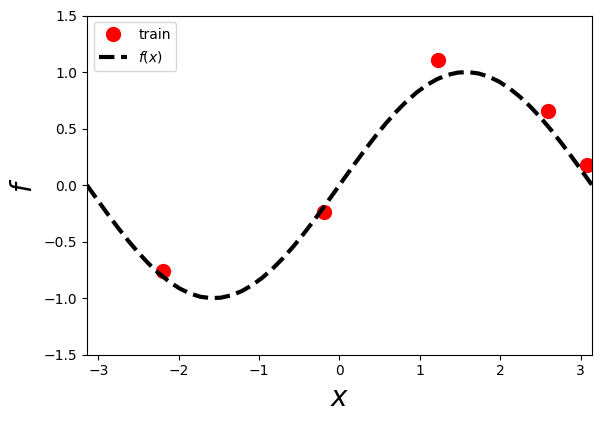

In [ ]:
from jax import random

key = random.PRNGKey(10)
train_points = 5
test_points = 50
noise_scale = 1e-1

target_fn = lambda x: jnp.sin(x)

key, x_key, y_key = random.split(key, 3)

train_xs = random.uniform(x_key, (train_points, 1), minval=-jnp.pi, maxval=jnp.pi)

train_ys = target_fn(train_xs)
train_ys += noise_scale * random.normal(y_key, (train_points, 1))
train = (train_xs, train_ys)

test_xs = jnp.linspace(-jnp.pi, jnp.pi, test_points)
test_xs = jnp.reshape(test_xs, (test_points, 1))

test_ys = target_fn(test_xs)
test = (test_xs, test_ys)

plot_fn(train, test)
legend(loc='upper left')
finalize_plot((0.85, 0.6))

In [ ]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(1, W_std=1.5, b_std=0.05)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')

In [ ]:
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs,
                                                      train_ys, diag_reg=1e-4)

nngp_mean, nngp_covariance = predict_fn(x_test=test_xs, get='nngp',
                                        compute_cov=True)

nngp_mean = jnp.reshape(nngp_mean, (-1,))
nngp_std = jnp.sqrt(jnp.diag(nngp_covariance))

plot_fn(train, test)
plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    jnp.reshape(test_xs, (-1)),
    nngp_mean - 2 * nngp_std,
    nngp_mean +  2 * nngp_std,
    color='red', alpha=0.2)

plt.xlim([-jnp.pi, jnp.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference'], loc='upper left')

finalize_plot((0.85, 0.6))